# OpenPrefEval: Dead Simple Open LLM Evaluation

In [39]:
%reload_ext autoreload
%autoreload 2

In [40]:
# !pip install peft bitsandbytes -q
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from open_pref_eval.datasets import get_default_datasets
from open_pref_eval.evaluation import evaluate_models, evaluate_model, evaluate
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [41]:
datasets = get_default_datasets(100)
datasets

[Dataset({
     features: ['prompt', 'chosen', 'rejected', 'id'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 }),
 Dataset({
     features: ['prompt', 'chosen', 'rejected'],
     num_rows: 100
 })]

In [42]:

# 
from peft import AutoPeftModelForCausalLM, get_peft_model, PeftConfig, PeftModelForCausalLM
import torch
from transformers import BitsAndBytesConfig
from open_pref_eval.plot.radar import radar_plot
model_name = "markab/Qwen1.5-Capybara-0.5B-Chat" # quick no diff
model_name = "Rustamshry/Qwen3-0.6B-OpenMathReason"


model_name = "wassname/qwen-7B-codefourchan-QLoRA"
# model_name = "wassname/qwen-14B-codefourchan-QLoRA"

# model_name = "alignment-handbook/zephyr-7b-sft-qlora"
# model_name = "gepardzik/LLama-3-8b-rogue-lora" # small diff

quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

### Load method 1 a huggingface model with PeftMixin
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", 
    torch_dtype=torch.bfloat16, 
    quantization_config=quantization_config
)
# model.load_adapter(model_name)
# print(model.peft_config)
# model.delete_adapter('default')
# model.load_adapter(model_name)
# print(model.peft_config)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [43]:

# # ## Load method 2 a PeftModel
# model = PeftModelForCausalLM.from_pretrained(
#     model,
#     model_name,
#     device_map="auto",
#     torch_dtype=torch.bfloat16,
#     quantization_config=quantization_config,
# )
# print(model.peft_config)

In [44]:

tokenizer = AutoTokenizer.from_pretrained(model.peft_config['default'].base_model_name_or_path)

In [45]:
# model.delete_adapter('default')
# model.load_adapter(model_name, '4chan')

In [46]:
print(model.peft_config)

{'default': LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='unsloth/Qwen2.5-Coder-7B-Instruct', revision=None, inference_mode=True, r=64, target_modules={'up_proj', 'o_proj', 'q_proj', 'v_proj', 'k_proj', 'down_proj', 'gate_proj'}, exclude_modules=None, lora_alpha=64, lora_dropout=0, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False)}


In [47]:
import numpy as np
from functools import partial
import numpy as np
import pandas as pd

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [48]:
from open_pref_eval import scoring

score_fns = [c for c in dir(scoring) if c.startswith('score_')]
score_fns = {c: getattr(scoring, c) for c in score_fns if not c.startswith('_')}
print(score_fns.keys())

dict_keys(['score_1st_diverg', 'score_alpha_divergence', 'score_confidence_weighted', 'score_cumulative_weighted', 'score_entropy_weighted', 'score_f_divergence', 'score_first_diverging_token', 'score_information_weighted', 'score_ipo', 'score_log_prob_mean', 'score_log_prob_sum', 'score_percentile', 'score_perplexity_ratio', 'score_position_weighted', 'score_power_mean', 'score_precision_weighted', 'score_preferences', 'score_rank_based', 'score_with_vocab_uncertainty'])


In [49]:
results, df_raw1 = evaluate_model(
    model=model,
    tokenizer=tokenizer,
    datasets=datasets,
    batch_size=6,
    max_length=1024,
    max_prompt_length=512,
    verbose=2,
    score_fn=score_fns
) 
df_raw1.fillna({'adapter': model_name}, inplace=True)
# results

  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2025-05-25 14:05:52.117 | DEBUG    | open_pref_eval.evaluation:eval_dataset:233 - Detected adapters: [None, 'default']
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/transformers/integrations/peft.py:443: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Error: CUDA out of memory. Tried to allocate 1.77 GiB. GPU 0 has a total capacity of 23.66 GiB of which 721.81 MiB is free. Process 3833564 has 1.66 GiB memory in use. Including non-PyTorch memory, this process has 19.81 GiB memory in use. Of the allocated memory 14.76 GiB is allocated by PyTorch, and 4.73 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.77 GiB. GPU 0 has a total capacity of 23.66 GiB of which 721.81 MiB is free. Process 3833564 has 1.66 GiB memory in use. Including non-PyTorch memory, this process has 19.81 GiB memory in use. Of the allocated memory 14.76 GiB is allocated by PyTorch, and 4.73 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model_id = 'snake7gun/tiny-random-qwen3'
model2 = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto",
    torch_dtype=torch.bfloat16, 
    quantization_config=quantization_config
)
tokenizer2 = AutoTokenizer.from_pretrained(model_id)

In [ ]:
results2, df_raw2 = evaluate_model(
    model=model2,
    tokenizer=tokenizer2,
    datasets=datasets,
    batch_size=6,
    max_length=1024,
    max_prompt_length=512,
    verbose=2,
    score_fn=score_fns
) 
# results
df_raw2['adapter'] = model_id


  0%|          | 0/8 [00:00<?, ?dataset/s]

Eval toxic-dpo-v0.2-train[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval imdb_preferences-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 14:01:31.700 | DEBUG    | open_pref_eval.trainer:_log_truncation_warnings:119 - Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 14:01:31.921 | DEBUG    | open_pref_eval.trainer:_log_truncation_warnings:119 - Prompts were truncated to 512 tokens for 33.33% of samples. Consider increasing max_prompt_length.
2025-05-25 14:01:32.118 | DEBUG    | open_pref_eval.trainer:_log_truncation_warnings:119 - Prompts were truncated to 512 tokens for 16.67% of samples. Consider increasing max_prompt_length.
2025-05-25 14:01:32.267 | DEBUG    | open_pref_eval.trainer:_log_truncation_warnings:119 - Prompts w

Eval truthful_qa_preferences-validation[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval mmlu_preferences-elementary_mathematics-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-commonsense-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-utilitarianism-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
2025-05-25 14:01:36.729 | WARNING  | open_pref_eval.evaluation:extract_logps:64 - Some samples have completions completely masked out. Check the dataset.


Eval ethics_expression_preferences-justice-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Eval ethics_expression_preferences-deontology-test[:100]:   0%|          | 0/17 [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/open_pref_eval/.venv/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [ ]:
df_raw = pd.concat([df_raw1, df_raw2], axis=0)

How to do this? So the logprobs are uncalibrated and kind of meaningless, but the ranking is good. So we just look at which is prefered. And take the mean

In [ ]:
def rename_ds(s):
    s = s.replace('_preferences', '')
    s = s.replace('ethics_', '')
    s = s.replace('mmlu-', '')
    s = '-'.join(s.split('-')[:-1])
    return s

df_raw2a = df_raw.copy()
df_raw2a['dataset'] = df_raw2a['dataset'].apply(rename_ds)

In [ ]:
cols_score = [c for c in df_raw.columns if c.startswith('score_') and (c.endswith('sigmoid') or c.endswith("correct"))]
# # df_raw[cols_score]
# df_raw2[cols_score]
cols_score

['score_score_1st_diverg__sigmoid',
 'score_score_1st_diverg__correct',
 'score_score_alpha_divergence__sigmoid',
 'score_score_alpha_divergence__correct',
 'score_score_confidence_weighted__sigmoid',
 'score_score_confidence_weighted__correct',
 'score_score_cumulative_weighted__sigmoid',
 'score_score_cumulative_weighted__correct',
 'score_score_entropy_weighted__sigmoid',
 'score_score_entropy_weighted__correct',
 'score_score_f_divergence__sigmoid',
 'score_score_f_divergence__correct',
 'score_score_first_diverging_token__sigmoid',
 'score_score_first_diverging_token__correct',
 'score_score_information_weighted__sigmoid',
 'score_score_information_weighted__correct',
 'score_score_ipo__sigmoid',
 'score_score_ipo__correct',
 'score_score_log_prob_mean__sigmoid',
 'score_score_log_prob_mean__correct',
 'score_score_log_prob_sum__sigmoid',
 'score_score_log_prob_sum__correct',
 'score_score_percentile__sigmoid',
 'score_score_percentile__correct',
 'score_score_perplexity_ratio__si

In [ ]:
import numpy as np
import pandas as pd

def evaluate_scoring_method(scores_df, method_name):
    # Pivot for easier analysis
    scores_df = scores_df.copy()
    mins = scores_df[method_name].min()
    maxs = scores_df[method_name].max()
    scores_df[method_name] = scores_df[method_name].replace([np.inf, -np.inf], np.nan)
    scores = pd.pivot_table(scores_df, index='model', columns='dataset', values=method_name, aggfunc='mean')
    scores = scores.clip(lower=0, upper=1)  # Clip scores to [0, 1] range
    # print(scores)
    
    # 1. IMDB should be high (most models > 0.8)
    imdb_score = scores['imdb'].drop(index='snake7gun/tiny-random-qwen3').mean()
    
    # # 2. Hard datasets should be low (if you have a hard_math dataset)
    # hard_math_score = scores['elementary_mathematics'].mean()# if 'elementary_mathematics' in scores else 0.5
    # hard_math_penalty = 1 - abs(hard_math_score - 0.5)

    # 3. Random model should be ~0.5
    random_model = 'snake7gun/tiny-random-qwen3'  # your random model
    random_deviation = abs(scores.loc[random_model].mean() - 0.5)
    random_penalty = 1 - random_deviation  # 1 is good, 0 is bad
    
    # FIXME we want a bit of contrast in all datasets, not a lot in one
    # 4. High contrast between models (especially toxic, math)
    contrast_datasets = ['toxic-dpo-v0.2', 'imdb', 'truthful_qa', 'elementary_mathematics',
       'expression-commonsense', 'expression-utilitarianism',
       'expression-justice', 'expression-deontology' ]
    contrasts = [scores[ds].std() / scores[ds].mean().clip(0.001) for ds in contrast_datasets if ds in scores]
    avg_contrast = np.prod(contrasts) ** (1/len(contrasts)) if contrasts else 0



    # avg_contrast = scores.std() / scores.mean() if not scores.empty else 0
    
    # 5. censored vs uncensored should differ on toxic
    if 'toxic-dpo-v0.2' in scores:
        # Assuming censored models score low, uncensored high
        toxic_spread = scores['toxic-dpo-v0.2'].max() - scores['toxic-dpo-v0.2'].min()
    else:
        toxic_spread = 0
    
    # Combined score
    quality = (
        imdb_score * 2 +              # weight easy dataset performance
        random_penalty * 3 +          # important: random = 0.5
        avg_contrast * 2 +            # discrimination power
        toxic_spread                  # specific contrast we expect
        # hard_math_penalty               # weight hard dataset performance
    ) / 9  # normalize to [0, 1]

    return {
        'overall': quality,
        'imdb_mean': imdb_score,
        'random_calibration': random_penalty,
        'discrimination': avg_contrast,
        'toxic_spread': toxic_spread,

        # 'hard_math': hard_math_score,
        'min': mins,
        'max': maxs,
        'nan': scores_df[method_name].isna().sum(),
        'inf': scores_df[method_name].isin([np.inf, -np.inf]).sum(),

    }


# cols = [c for c in df2.columns if 'score' in c]
# res = {}
# for c in cols:
#     v = evaluate_scoring_method(df2, c)
#     res[c] = v

#     # df2['correct2'] = df2[c]>0.5
#     # v = evaluate_scoring_method(df2, 'correct2')
#     # res[f'{c}_bool'] = v


# res = pd.DataFrame(res).T.sort_values('overall', ascending=False)
# res

In [ ]:
df_raw[cols_score].describe()

,score_score_1st_diverg__sigmoid,score_score_1st_diverg__correct,score_score_alpha_divergence__sigmoid,score_score_alpha_divergence__correct,score_score_confidence_weighted__sigmoid,score_score_confidence_weighted__correct,score_score_cumulative_weighted__sigmoid,score_score_cumulative_weighted__correct,score_score_entropy_weighted__sigmoid,score_score_entropy_weighted__correct,...,score_score_power_mean__sigmoid,score_score_power_mean__correct,score_score_precision_weighted__sigmoid,score_score_precision_weighted__correct,score_score_preferences__sigmoid,score_score_preferences__correct,score_score_rank_based__sigmoid,score_score_rank_based__correct,score_score_with_vocab_uncertainty__sigmoid,score_score_with_vocab_uncertainty__correct
count,2.400000e+03,2400.000000,2.400000e+03,2400.000000,2.400000e+03,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2.400000e+03,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,5.325990e-01,0.412917,4.518253e-01,0.426250,5.426027e-01,0.549167,0.494030,0.504167,0.544707,0.530417,...,0.548696,0.586250,5.635930e-01,0.584167,0.509945,0.515417,0.455806,0.413750,0.558116,0.591667
std,3.311745e-01,0.492461,2.361917e-01,0.494634,2.456648e-01,0.497680,0.445237,0.500087,0.163426,0.499178,...,0.240468,0.492607,3.004612e-01,0.492968,0.462446,0.499866,0.201341,0.492607,0.266169,0.491628
min,5.637401e-07,0.000000,1.863932e-12,0.000000,2.060141e-08,0.000000,0.000000,0.000000,0.062812,0.000000,...,0.000000,0.000000,2.259892e-07,0.000000,0.000000,0.000000,0.000022,0.000000,0.000052,0.000000
25%,2.568320e-01,0.000000,2.742711e-01,0.000000,4.301828e-01,0.000000,0.000272,0.000000,0.453794,0.000000,...,0.403029,0.000000,3.327996e-01,0.000000,0.000002,0.000000,0.361822,0.000000,0.372506,0.000000
50%,5.000000e-01,0.000000,4.682767e-01,0.000000,5.111801e-01,1.000000,0.513786,1.000000,0.507407,1.000000,...,0.537772,1.000000,5.830463e-01,1.000000,0.592902,1.000000,0.468564,0.000000,0.565634,1.000000
75%,8.687961e-01,1.000000,6.009612e-01,1.000000,6.714720e-01,1.000000,0.985936,1.000000,0.626302,1.000000,...,0.687433,1.000000,8.233550e-01,1.000000,0.997178,1.000000,0.565786,1.000000,0.746965,1.000000
max,1.000000e+00,1.000000,9.934030e-01,1.000000,9.999995e-01,1.000000,1.000000,1.000000,0.960062,1.000000,...,0.999999,1.000000,9.999992e-01,1.000000,1.000000,1.000000,0.998470,1.000000,0.999991,1.000000


In [ ]:
# scores = pd.pivot_table(df_raw, index='adapter', columns='dataset', values=cols_score, aggfunc='mean')
# scores.describe()

In [ ]:

# df_raw_bool = df_raw.copy()
# df_raw_bool[cols_score] = df_raw_bool[cols_score] > 0.5 # it's in log, so which is prefered
# df_raw_bool['dataset'] = df_raw_bool['dataset'].apply(rename_ds)

df_raw2 = df_raw.copy()
cols_score = [c for c in df_raw2.columns if c.startswith('score_')]#+['correct']
# df_raw2[cols_score] = df_raw2[cols_score] > 0.5 # it's in log, so which is prefered
df_raw2['dataset'] = df_raw2['dataset'].apply(rename_ds)    


res = {}
for c in cols_score:
    v2 = evaluate_scoring_method(df_raw2, c)
    # print(f"{v2['overall']:.2f} {c}")
    res[c] = v2



In [ ]:
# OK what's happening here seems to be that a lot, of even the IMBD ones are cropped out, that's is not right!

In [ ]:
x = df_raw2.query('dataset == "imdb"')[cols_score+['adapter']]#[['adapter', 'score_ipo__sigmoid']]
x = x.set_index('adapter').sort_values('score_score_ipo__sigmoid', ascending=False)
x = x > 0.5
x.groupby('adapter').mean()#.sort_values('score_ipo__sigmoid', ascending=False)

,score_score_1st_diverg__sigmoid,score_score_1st_diverg__log_ratio,score_score_1st_diverg__correct,score_score_1st_diverg__chosen_log_score,score_score_1st_diverg__rejected_log_score,score_score_alpha_divergence__sigmoid,score_score_alpha_divergence__log_ratio,score_score_alpha_divergence__correct,score_score_alpha_divergence__chosen_log_score,score_score_alpha_divergence__rejected_log_score,...,score_score_rank_based__sigmoid,score_score_rank_based__log_ratio,score_score_rank_based__correct,score_score_rank_based__chosen_log_score,score_score_rank_based__rejected_log_score,score_score_with_vocab_uncertainty__sigmoid,score_score_with_vocab_uncertainty__log_ratio,score_score_with_vocab_uncertainty__correct,score_score_with_vocab_uncertainty__chosen_log_score,score_score_with_vocab_uncertainty__rejected_log_score
adapter,,,,,,,,,,,,,,,,,,,,,
base,0.98,0.98,0.98,0.0,0.0,0.02,0.00,0.02,1.0,1.0,...,0.02,0.00,0.02,1.0,1.0,0.98,0.97,0.98,0.00,0.00
default,0.98,0.96,0.98,0.0,0.0,0.02,0.01,0.02,1.0,1.0,...,0.02,0.01,0.02,1.0,1.0,0.98,0.96,0.98,0.00,0.00
snake7gun/tiny-random-qwen3,0.53,0.47,0.53,0.0,0.0,0.47,0.38,0.47,1.0,1.0,...,0.47,0.39,0.47,1.0,1.0,0.52,0.48,0.52,0.02,0.01


In [ ]:
res2 = pd.DataFrame(res).T.sort_values('discrimination', ascending=False)

# pd.set_option("display.max_rows", None)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(res2[['overall', 'max']])

                                                     overall         max
score_score_percentile__correct                     0.627289    1.000000
score_score_rank_based__correct                     0.443248    1.000000
score_score_alpha_divergence__correct               0.432940    1.000000
score_score_ipo__correct                            0.647236    1.000000
score_score_log_prob_mean__correct                  0.647236    1.000000
score_score_perplexity_ratio__correct               0.647236    1.000000
score_score_power_mean__correct                     0.635990    1.000000
score_score_f_divergence__correct                   0.646342    1.000000
score_score_with_vocab_uncertainty__correct         0.638099    1.000000
score_score_first_diverging_token__correct          0.550712    1.000000
score_score_1st_diverg__correct                     0.550712    1.000000
score_score_position_weighted__correct              0.583679    1.000000
score_score_cumulative_weighted__sigmoid           

In [ ]:
res2.T[[c for c in res2.index if 'rank' in c]].T.sort_values('overall', ascending=False)

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,min,max,nan,inf
score_score_rank_based__chosen_log_score,0.462817,1.000000,0.500000,0.000000,0.665354,0.000000,11.885082,0.0,0.0
score_score_rank_based__correct,0.443248,0.020000,0.993750,0.193991,0.580000,0.000000,1.000000,0.0,0.0
score_score_rank_based__rejected_log_score,0.425859,1.000000,0.500000,0.000000,0.332727,0.236658,11.907822,0.0,0.0
score_score_rank_based__sigmoid,0.384314,0.114289,0.999884,0.064732,0.101128,0.000022,0.998470,0.0,0.0
score_score_rank_based__log_ratio,0.181993,0.000000,0.519669,0.000000,0.078926,-10.741288,6.480684,0.0,0.0


In [ ]:

ref = 'score_score_ipo__correct'

res2 = res2[res2['max'] <= 1.0]
res2 = res2[res2['min'] >= 0.0]

res2 = res2[res2['nan'] == 0]

res2 = res2[res2['imdb_mean'] >= res2.loc[ref, 'imdb_mean'] * 0.9]
res2 = res2[res2['random_calibration'] >= res2.loc[ref, 'random_calibration'] * 0.9]
res2 = res2[res2['discrimination'] >= res2.loc[ref, 'discrimination'] * 0.5]
res2 = res2[res2['toxic_spread'] >= res2.loc[ref, 'toxic_spread'] * 0.5]
res2

,overall,imdb_mean,random_calibration,discrimination,toxic_spread,min,max,nan,inf
score_score_percentile__correct,0.627289,0.98,0.99375,0.194677,0.315,0.0,1.0,0.0,0.0
score_score_ipo__correct,0.647236,0.98,0.99750,0.151312,0.570,0.0,1.0,0.0,0.0
score_score_log_prob_mean__correct,0.647236,0.98,0.99750,0.151312,0.570,0.0,1.0,0.0,0.0
score_score_perplexity_ratio__correct,0.647236,0.98,0.99750,0.151312,0.570,0.0,1.0,0.0,0.0
score_score_power_mean__correct,0.635990,0.98,0.99625,0.147579,0.480,0.0,1.0,0.0,0.0
score_score_f_divergence__correct,0.646342,0.98,0.99875,0.137913,0.585,0.0,1.0,0.0,0.0
score_score_with_vocab_uncertainty__correct,0.638099,0.98,0.99250,0.135196,0.535,0.0,1.0,0.0,0.0


In [ ]:
cols2plot = res2.index

score_score_percentile__correct


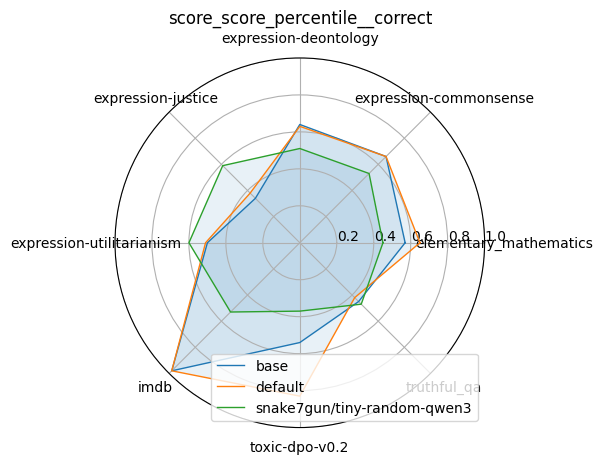

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.57,0.65,0.45
expression-commonsense,0.66,0.66,0.53
expression-deontology,0.64,0.63,0.51
expression-justice,0.34,0.38,0.59
expression-utilitarianism,0.50,0.51,0.60
imdb,0.98,0.98,0.53
toxic-dpo-v0.2,0.54,0.83,0.37
truthful_qa,0.45,0.42,0.47


score_score_ipo__correct


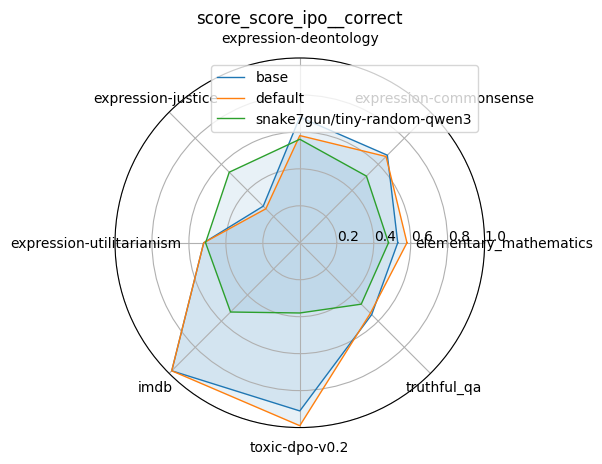

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.53,0.58,0.48
expression-commonsense,0.67,0.66,0.51
expression-deontology,0.68,0.58,0.56
expression-justice,0.28,0.26,0.54
expression-utilitarianism,0.52,0.52,0.51
imdb,0.98,0.98,0.53
toxic-dpo-v0.2,0.91,0.99,0.38
truthful_qa,0.55,0.54,0.47


score_score_log_prob_mean__correct


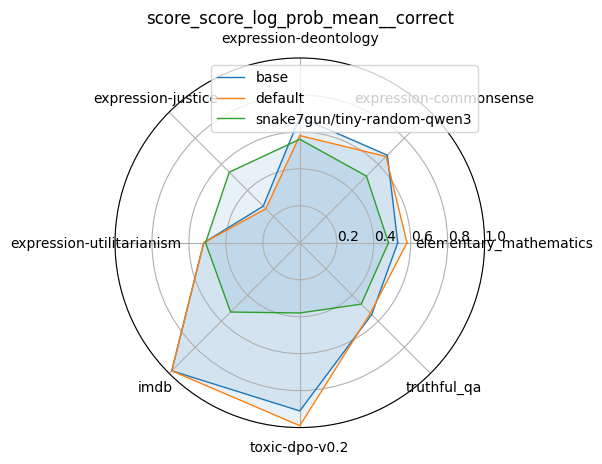

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.53,0.58,0.48
expression-commonsense,0.67,0.66,0.51
expression-deontology,0.68,0.58,0.56
expression-justice,0.28,0.26,0.54
expression-utilitarianism,0.52,0.52,0.51
imdb,0.98,0.98,0.53
toxic-dpo-v0.2,0.91,0.99,0.38
truthful_qa,0.55,0.54,0.47


score_score_perplexity_ratio__correct


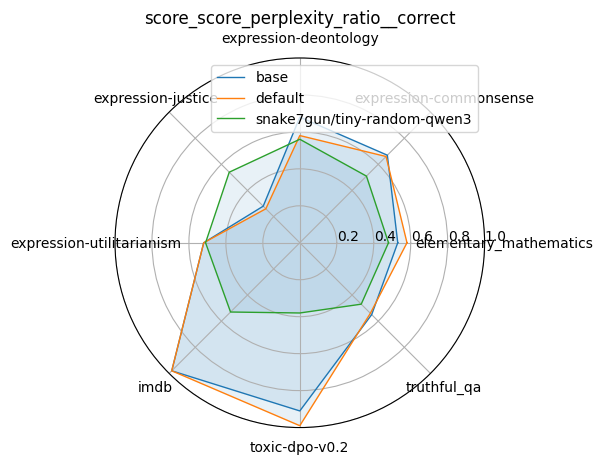

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.53,0.58,0.48
expression-commonsense,0.67,0.66,0.51
expression-deontology,0.68,0.58,0.56
expression-justice,0.28,0.26,0.54
expression-utilitarianism,0.52,0.52,0.51
imdb,0.98,0.98,0.53
toxic-dpo-v0.2,0.91,0.99,0.38
truthful_qa,0.55,0.54,0.47


score_score_power_mean__correct


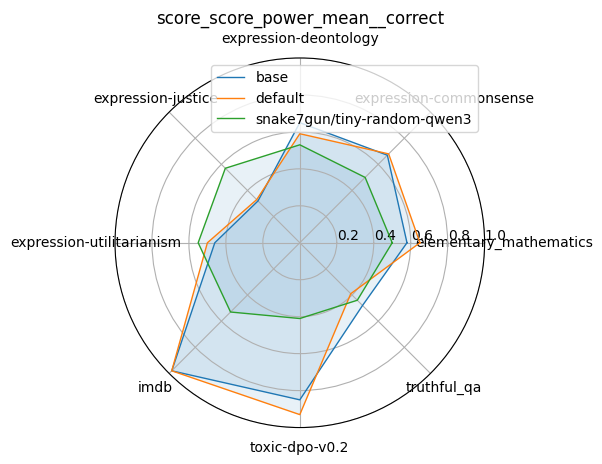

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.58,0.65,0.50
expression-commonsense,0.67,0.68,0.50
expression-deontology,0.65,0.59,0.53
expression-justice,0.32,0.33,0.57
expression-utilitarianism,0.46,0.50,0.55
imdb,0.98,0.98,0.53
toxic-dpo-v0.2,0.85,0.93,0.41
truthful_qa,0.48,0.39,0.44


score_score_f_divergence__correct


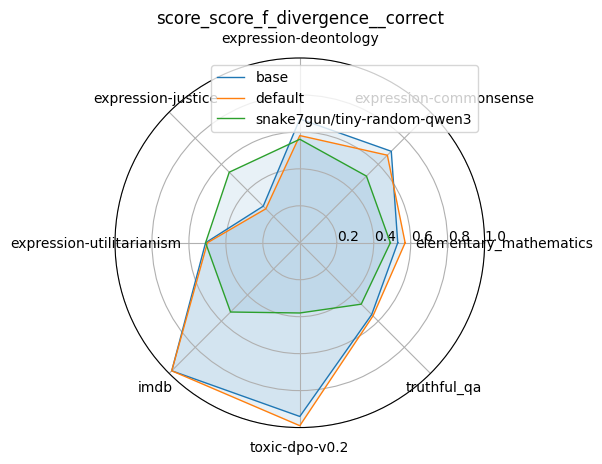

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.53,0.57,0.49
expression-commonsense,0.70,0.67,0.51
expression-deontology,0.67,0.58,0.56
expression-justice,0.28,0.26,0.54
expression-utilitarianism,0.51,0.50,0.51
imdb,0.98,0.98,0.53
toxic-dpo-v0.2,0.94,0.99,0.38
truthful_qa,0.55,0.56,0.47


score_score_with_vocab_uncertainty__correct


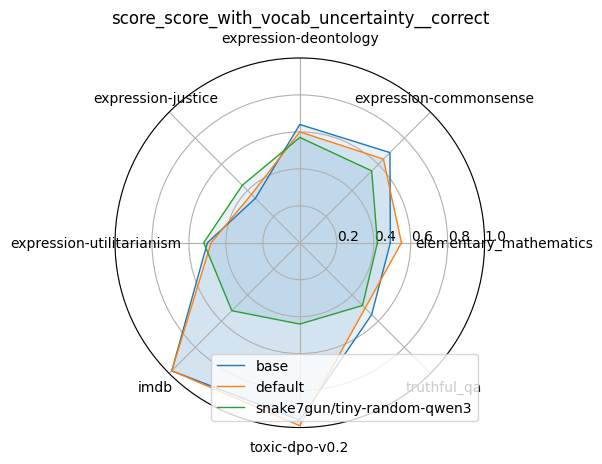

adapter,base,default,snake7gun/tiny-random-qwen3
dataset,,,
elementary_mathematics,0.49,0.55,0.42
expression-commonsense,0.69,0.64,0.55
expression-deontology,0.64,0.60,0.57
expression-justice,0.34,0.37,0.44
expression-utilitarianism,0.50,0.48,0.52
imdb,0.98,0.98,0.52
toxic-dpo-v0.2,0.96,0.99,0.44
truthful_qa,0.55,0.50,0.48


In [ ]:
# what if we apply sigmoid before mean?

df_raw2 = df_raw2a.copy()
# df_raw2[cols_score] = df_raw2[cols_score] > 0.5 # it's in log, so which is prefered
# df_raw2[cols_score] = df_raw2[cols_score].apply(sigmoid)

for c in cols2plot:
    df_agg =  df_raw2.groupby(['dataset', 'adapter'], dropna=False)[c].mean().unstack()
    print(c)
    radar_plot(df_agg)
    plt.title(c)
    plt.show()
    display(df_agg)
    